# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset for computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction)
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 100

Let's start with loading the dataset and check how it looks like
> **In case of problems with downloading dataset via torchvison please use the second method**

In [2]:
# load the MINST dataset via torchvision
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

In [4]:
len(train_subset)

50000

In [3]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Second method: directly download tar.gz archive

In [19]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

Plot sample images

50000
10000
10000
391
torch.Size([28, 28])


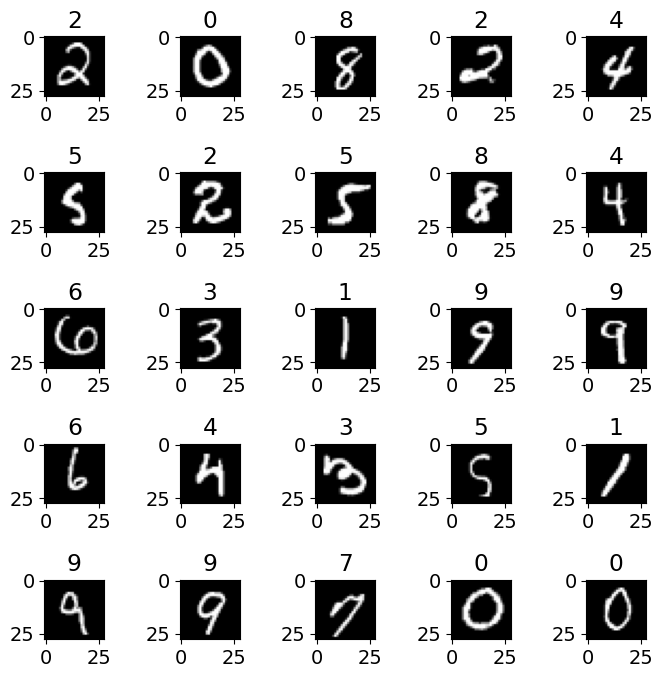

In [20]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with simplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [39]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        # 4 kernels of size 5x5
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d(0.6)
        # fully connected layers
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 4 feature maps each of size 8x8
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 256) # 4 maps of 4x4 size gives 64 numbers
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc3(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


And define training, testing, and plotting utils:

In [22]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean')
            # get the index of class with the max log-probability
            prediction = output.argmax(dim=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

In [25]:
test_loader.batch_size

128

## Experiments

1. At first let's test the single-layer *Perceptron* model



Train Epoch: 1 [0/50000 (0%)]	Loss: 2.580849
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.450388
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.191844
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.279519

Train set: Average loss: 0.3742
Validation set: Average loss: 0.3268, Accuracy: 9064/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.270903
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.307292
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.301347
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.163701

Train set: Average loss: 0.2998
Validation set: Average loss: 0.3147, Accuracy: 9106/10000 (91%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.219255
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.187627
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.236442
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.272858

Train set: Average loss: 0.2861
Validation set: Average loss: 0.3075, Accuracy: 9109/10000 (91%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.370575
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.225651
Train Epoch: 4 [25600/5

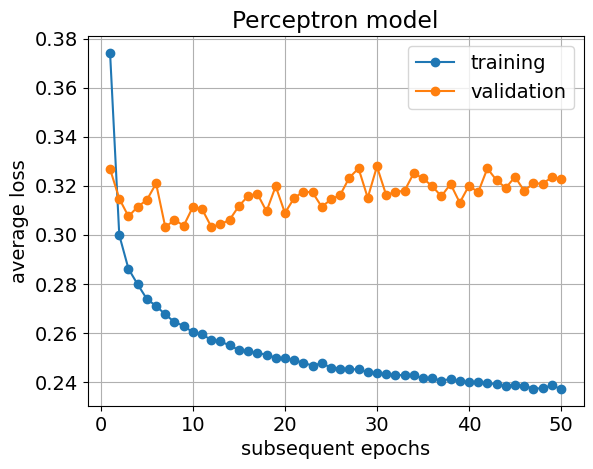

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.402434
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.463317
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.205195
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.276179

Train set: Average loss: 0.4156
Validation set: Average loss: 0.2936, Accuracy: 9138/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.291207
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.224197
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.240429
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.121124

Train set: Average loss: 0.2454
Validation set: Average loss: 0.2477, Accuracy: 9297/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.141703
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.203007
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.160000
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.186231

Train set: Average loss: 0.2017
Validation set: Average loss: 0.2189, Accuracy: 9378/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.296588
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.120948
Train Epoch: 4 [25600/5

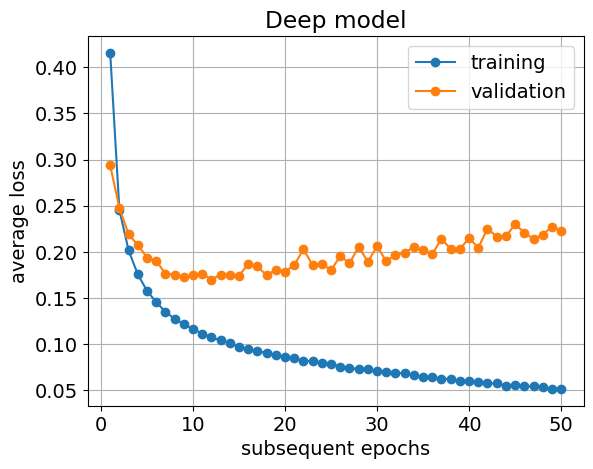

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.275550
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.419313
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.907669
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.796020

Train set: Average loss: 1.1455
Validation set: Average loss: 0.3722, Accuracy: 8862/10000 (89%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.825818
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.750544
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.726835
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.462616

Train set: Average loss: 0.6795
Validation set: Average loss: 0.2543, Accuracy: 9268/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.632071
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.509636
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.554340
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.464210

Train set: Average loss: 0.5858
Validation set: Average loss: 0.2125, Accuracy: 9370/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.702858
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.694755
Train Epoch: 4 [25600/5

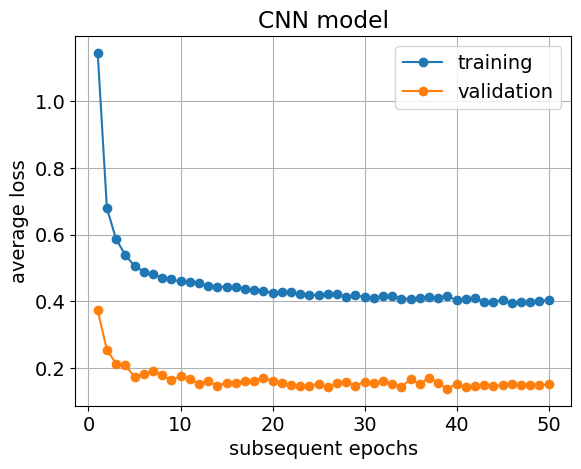

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

## Summary
* *Deep* and *CNN* models with accuracies of 96% and 97% (evaluated on the test subset) perform much better than single-layer *Perceptron* with 92%;
* The two smallest (and simplest) models appear to be overfitted. To deal with this we need to apply some regularization.
* Validation subset is evaluated during the training (as opposed to test set, infered *after* the training) in order to tune the model hiperparameters (that describe e.g. the network structure, or training details).
* A moment to stop trainning is a kind of hipermarameter -- by applying *early stopping* we can avoid overfitting.



## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting (start with nonzero *weight_decay* in optimizer)
* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),
* **tune one of these models to get the *Test Set Accuracy* > 99%**,
* plot the *confusion matrix* among all of the classes---which of digits are mostly confused with each other?
>How to build the confusion matrix?
> * for example 1st row represents images with "0" digit (*ground truth*), while 1st colum images for which the model *predicts* "0",
> * this way element _11 is equal to number of images with "0" corectly clasified as "0" (true positives), while _15 means number of images with "0" wrongly calssified as "4", and so on.

-
- Dropout means that only certain neurons in the network are used, and therefore perform less well, whereas during validation all the neurons are used. It is like EnsembleLearning
- I have 99% accuracy by changing the size of CNN from 1-->2-->4 to 1-->16-->16 and only 10 epochs
-

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.443918
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.283667
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.462003
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.449897

Train set: Average loss: 0.3766
Validation set: Average loss: 0.3097, Accuracy: 9103/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.252466
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.361559
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.212134
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.318259

Train set: Average loss: 0.3046
Validation set: Average loss: 0.3054, Accuracy: 9101/10000 (91%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.236149
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.364981
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.304518
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.313872

Train set: Average loss: 0.2925
Validation set: Average loss: 0.2983, Accuracy: 9158/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.260569
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.338870
Train Epoch: 4 [25600/5


Train set: Average loss: 0.2587
Validation set: Average loss: 0.2854, Accuracy: 9197/10000 (92%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.243116
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.334774
Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.147858
Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.206633

Train set: Average loss: 0.2592
Validation set: Average loss: 0.2845, Accuracy: 9193/10000 (92%)

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.571354
Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.147935
Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.436740
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.240441

Train set: Average loss: 0.2589
Validation set: Average loss: 0.2902, Accuracy: 9195/10000 (92%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.189349
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.225008
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.150457
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.270616

Train set: Average loss: 0.2583
Validation set: Average loss: 0.2874, Accuracy: 9186/10000 (92%)

Train E

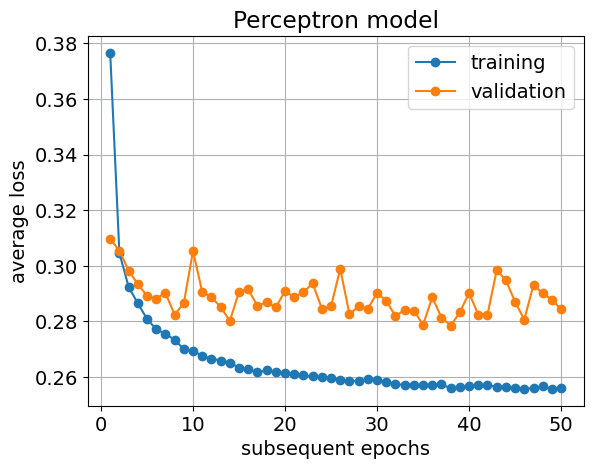

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], weight_decay = 0.001, momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.362840
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.204333
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.177868
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.259073

Train set: Average loss: 0.3551
Validation set: Average loss: 0.1070, Accuracy: 9667/10000 (97%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.153500
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.141228
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.080524
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.261890

Train set: Average loss: 0.1675
Validation set: Average loss: 0.0857, Accuracy: 9745/10000 (97%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.167422
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.097200
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.146517
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.104831

Train set: Average loss: 0.1397
Validation set: Average loss: 0.0653, Accuracy: 9797/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.106106
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.232701
Train Epoch: 4 [25600/5


Train set: Average loss: 0.0541
Validation set: Average loss: 0.0315, Accuracy: 9898/10000 (99%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.022158
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.146897
Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.046841
Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.085364

Train set: Average loss: 0.0510
Validation set: Average loss: 0.0370, Accuracy: 9886/10000 (99%)

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.047358
Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.034122
Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.093106
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.032260

Train set: Average loss: 0.0493
Validation set: Average loss: 0.0380, Accuracy: 9886/10000 (99%)

Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99%)



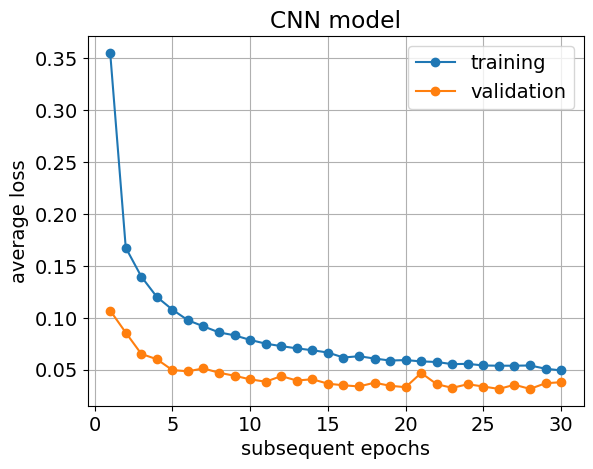

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, 30 + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

In [41]:
y_pred = []
y_true = []
model.eval()
for data, y_real in test_loader:
    data, target = data.to(device), y_real.to(device)
    y_pred.append(model(data).argmax(dim=1))
    y_true.append(y_real)

In [42]:
a = torch.cat((y_pred[0],y_pred[1]), dim=0)
b = torch.cat((y_true[0],y_true[1]), dim=0)
for i in range(2,len(y_pred)):
    a = torch.cat((a, y_pred[i]), dim=0)
    b = torch.cat((b, y_true[i]), dim=0)

ypred = a.to('cpu')
yreal = b.to('cpu')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

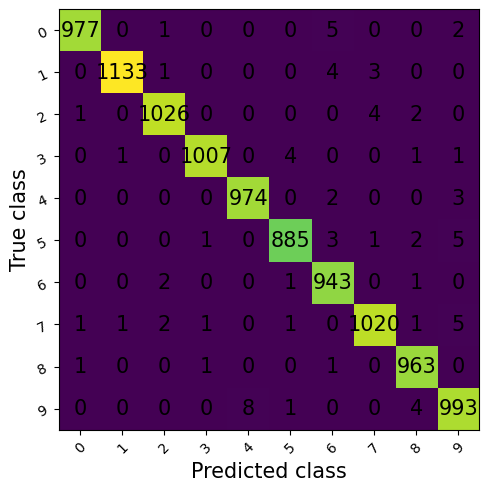

In [43]:
from torchmetrics.classification import ConfusionMatrix
metric = ConfusionMatrix(task="multiclass", num_classes=10)
metric.update(ypred, yreal)

metric.plot()